In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
#for adding heavy chain
complementator = str.maketrans("ACGT", "TGCA") 

In [3]:
# for making plots:
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}

In [4]:
# reference:
ref_annot = pd.read_csv('ref_annot.csv')

In [5]:
ref_annot

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16564,16565,C,ACG,-1,D-loop,NaN,-1,-1,NaN,NaN
16565,16566,G,CGA,-1,D-loop,NaN,-1,-1,NaN,NaN
16566,16567,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
16567,16568,T,ATG,-1,D-loop,NaN,-1,-1,NaN,NaN


In [6]:
REGION_SIZE = 50

In [7]:
WINDOW_SIZE = 10

---

## Data preparation 
## Step 1
- auto-annotate G4 by G4Hunter (https://bioinformatics.cruk.cam.ac.uk/G4Hunter/)  
- *verificate auto-annotate G4 in human RefSeq using data from africa paper and exel*  

Dataset from paper [DOI:10.1093/nar/gkw006](DOI:10.1093/nar/gkw006) (G4Hunter and *in vitro* checking G4)

In [8]:
datasetG4 = pd.read_excel("SupplementaryTableS2.xlsx")

C:\Users\777\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\777\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [9]:
datasetG4

,name,seqnames,start,end,width,strand,seq,G4Hscore,Type,QP27,QP37,QP312,G4H1,G4H1.2,G4H1.5,G4H1.7,G4H2,Type (G4),Type (G4 or UG4)
0,Mito 1,EF184640.1,47,90,44,+,GCATTTGGTATTTTCGTCTGGGGGGTGTGCACGCGATAGCATTG,0.66,notG4,-,-,-,+,-,-,-,-,-,-
1,Mito 2,EF184640.1,144,168,25,-,CCCCATCCTATTATTTATCGCACCT,-1.00,UG4,-,-,-,+,-,-,-,-,-,+
2,Mito 3,EF184640.1,294,317,24,-,TCCACCAAACCCCCCCTCCCCCCG,-2.46,G4,+,-,-,+,+,+,+,+,+,+
3,Mito 4,EF184640.1,349,379,31,-,CCAAACCCCAAAAACAAAGAACCCTAACACC,-1.10,UG4,-,-,-,+,-,-,-,-,-,+
4,Mito 5,EF184640.1,432,471,40,-,CACCCCCCAACTAACACATTATTTTCCCCTCCCACTCCCA,-1.57,G4,-,-,-,+,+,-,-,-,+,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Mito 0.5-40,EF184640.1,221,245,25,+,GCTTGTAGGACATAATAATAACAGT,0.16,notG4,-,-,-,-,-,-,-,-,-,-
205,Mito 0.5-41,EF184640.1,603,627,25,+,CAATGCACTGAAAATGTTTAGACGG,0.16,notG4,-,-,-,-,-,-,-,-,-,-
206,Mito 0.5-42,EF184640.1,1328,1352,25,+,GGTCAAGGTGTAGCCCATGAGGTGG,0.36,notG4,-,-,-,-,-,-,-,-,-,-
207,Mito 0.5-43,EF184640.1,1339,1363,25,+,AGCCCATGAGGTGGCAAGAAATGGG,0.40,notG4,-,-,-,-,-,-,-,-,-,-


In [10]:
africaG4 = datasetG4[datasetG4['Type'] != 'notG4'][['seqnames','start','end', 'width', 'strand', 'seq', 'G4Hscore', 'Type']]

In [11]:
africaG4

,seqnames,start,end,width,strand,seq,G4Hscore,Type
1,EF184640.1,144,168,25,-,CCCCATCCTATTATTTATCGCACCT,-1.00,UG4
2,EF184640.1,294,317,24,-,TCCACCAAACCCCCCCTCCCCCCG,-2.46,G4
3,EF184640.1,349,379,31,-,CCAAACCCCAAAAACAAAGAACCCTAACACC,-1.10,UG4
4,EF184640.1,432,471,40,-,CACCCCCCAACTAACACATTATTTTCCCCTCCCACTCCCA,-1.57,G4
5,EF184640.1,457,484,28,-,CCCCTCCCACTCCCATACTACTAATCTC,-1.39,G4
...,...,...,...,...,...,...,...,...
192,EF184640.1,13364,13384,21,-,CCGGGTCCATCATCCACAACC,-0.43,UG4
193,EF184640.1,13838,13860,23,-,CCCTAGACCTCAACTACCTAACC,-0.96,G4
194,EF184640.1,14043,14074,32,-,CCAAATCTCCACCTCCATCATCACCTCAACCC,-1.03,UG4
199,EF184640.1,15727,15743,17,-,CCTAGCCGCAGACCTCC,-0.82,UG4


In [12]:
# africaG4.to_excel('africaG4.xlsx')

In [36]:
refG4 = pd.read_table('NC_012920.1 Homo sapiens mitochondrion, complete genome_DNA_hl=1_k=25_G4Hseeked_2023-09-22.txt')

In [37]:
refG4

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",47,90,44,+,0.636,1.12,1,25,GCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTG
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",702,728,27,-,-1.040,-1.08,1,25,CATCCCCGTTCCAGTGAGTTCACCCTC
...,...,...,...,...,...,...,...,...,...,...
89,"NC_012920.1 Homo sapiens mitochondrion, comple...",16033,16049,17,+,1.530,1.00,1,25,GGGGAAGCAGATTTGGG
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC


In [15]:
# refG4.to_excel('refG4.xlsx')
# refG4['sequence'].to_excel('refG4seq.xlsx')  #used for annotation G4
# africaG4['seq'].to_excel('africaG4seq.xlsx')

### Manually fill in the data  
Compare two datasets africaG4, refG4  
If G4 present in both datasets put **1** in column *confirm*

## Step 2
### Interval size analysis  
*start here*

In [38]:
refG4 = pd.read_excel('refG4.xlsx')

In [39]:
g4conf = refG4[refG4['confirmed'] == 1]

In [40]:
g4conf.head()

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.25,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.10,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.15,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.21,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.39,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084


In [8]:
a = g4conf['start'].drop(1).values - g4conf['end'].drop(93).values

In [9]:
min(g4conf['start'].drop(1).values - g4conf['end'].drop(93).values)

6

In [10]:
sum(g4conf['start'].drop(1).values - g4conf['end'].drop(93).values < 100)

33

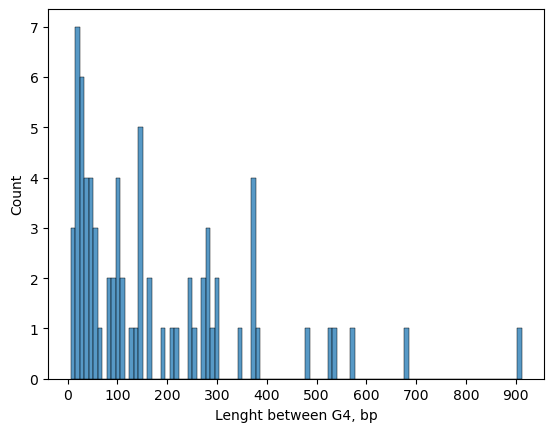

In [11]:
fig, ax = plt.subplots()
sns.histplot(a, bins=100, ax=ax)
ax.set_xticks(range(0,1000, 100))
ax.set(xlabel='Lenght between G4, bp')
plt.show()

The distance between G4 is often less than 100bp

Therefore, we take the intervals between G4 = 50 bp,  
If the interval between G4 < 50bp, then we do not take G4 into analysis

In [41]:
REGION_SIZE = 50

In [42]:
WINDOW_SIZE = 10

Add new columns:

In [43]:
refG4[f'start-{REGION_SIZE}bp'] = refG4['start'] - REGION_SIZE

In [44]:
refG4[f'end+{REGION_SIZE}bp'] = refG4['end'] + REGION_SIZE

Choose only confirmed G4:

In [45]:
g4conf = refG4[refG4['confirmed'] == 1]

In [46]:
g4conf.shape

(74, 17)

Add column with distance between confirmed G4:

In [47]:
bp_untill_next_G4 = g4conf['start'].drop(1).values - g4conf['end'].drop(93).values
bp_untill_next_G4 = bp_untill_next_G4.tolist()
bp_untill_next_G4.append(294)  #294 bp between last G4 and first G4

In [48]:
bp_untill_previous_G4 = g4conf['start'].drop(1).values - g4conf['end'].drop(93).values
bp_untill_previous_G4 = bp_untill_previous_G4.tolist()
bp_untill_previous_G4.insert(0, 294)

In [49]:
g4conf['bp_untill_next_G4'] = bp_untill_next_G4
g4conf['bp_untill_previous_G4'] = bp_untill_previous_G4

C:\Users\777\AppData\Local\Temp\ipykernel_11528\2987571035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g4conf['bp_untill_next_G4'] = bp_untill_next_G4
C:\Users\777\AppData\Local\Temp\ipykernel_11528\2987571035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g4conf['bp_untill_previous_G4'] = bp_untill_previous_G4


In [50]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432,235,382,16,294
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478,298,428,40,16
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692,368,642,193,40
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908,735,858,146,193
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084,904,1034,683,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,1,UG4,more than africa,15536,15783,15586,15733,484,80
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,1,G4,more than africa,16067,16311,16117,16261,28,484
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,1,G4,more than africa,16139,16401,16189,16351,43,28
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,1,UG4,more than africa,16244,16482,16294,16432,145,43


Adding G4_id for each confirmed G4:

In [51]:
g4conf['G4_id'] = [*range(1,g4conf.shape[0]+1)]

C:\Users\777\AppData\Local\Temp\ipykernel_11528\169449425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g4conf['G4_id'] = [*range(1,g4conf.shape[0]+1)]


In [52]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432,235,382,16,294,1
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478,298,428,40,16,2
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692,368,642,193,40,3
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908,735,858,146,193,4
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084,904,1034,683,146,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,1,UG4,more than africa,15536,15783,15586,15733,484,80,70
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,1,G4,more than africa,16067,16311,16117,16261,28,484,71
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,1,G4,more than africa,16139,16401,16189,16351,43,28,72
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,1,UG4,more than africa,16244,16482,16294,16432,145,43,73


In [53]:
g4conf['up_win'] = pd.concat([g4conf[g4conf['bp_untill_previous_G4'] <= 100][['bp_untill_previous_G4', 'start']].diff(axis=1)['start'],\
                                 g4conf[g4conf['bp_untill_previous_G4'] > 100]['start']-100])

C:\Users\777\AppData\Local\Temp\ipykernel_11528\2099197523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g4conf['up_win'] = pd.concat([g4conf[g4conf['bp_untill_previous_G4'] <= 100][['bp_untill_previous_G4', 'start']].diff(axis=1)['start'],\


In [54]:
g4conf['down_win'] = pd.concat([g4conf[g4conf['bp_untill_next_G4'] <= 100][['end', 'bp_untill_next_G4']].sum(axis=1), \
                               g4conf[g4conf['bp_untill_next_G4'] > 100]['end']+100])

C:\Users\777\AppData\Local\Temp\ipykernel_11528\461284617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g4conf['down_win'] = pd.concat([g4conf[g4conf['bp_untill_next_G4'] <= 100][['end', 'bp_untill_next_G4']].sum(axis=1), \


In [55]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,...,more than africa,185,432,235,382,16,294,1,185,348
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,...,less than africa,248,478,298,428,40,16,2,332,418
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,...,more than africa,15536,15783,15586,15733,484,80,70,15556,15783
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,...,more than africa,16067,16311,16117,16261,28,484,71,16067,16239
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,...,more than africa,16139,16401,16189,16351,43,28,72,16211,16344
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,...,more than africa,16244,16482,16294,16432,145,43,73,16301,16482


In [121]:
g4conf[(g4conf['G4_id'] == 38) | (g4conf['G4_id'] == 39)] 

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
37,"NC_012920.1 Homo sapiens mitochondrion, comple...",9243,9262,20,-,-1.65,-1.32,1,25,CCCAGCCCATGACCCCTAAC,...,less than africa,9143,9362,9193,9312,6,285,38,9143,9268
38,"NC_012920.1 Homo sapiens mitochondrion, comple...",9268,9293,26,-,-1.15,-1.12,1,25,CCCTCTCAGCCCTCCTAATGACCTCC,...,NaN,9168,9393,9218,9343,212,6,39,9262,9393


In [57]:
# g4conf.to_csv('g4conf.csv', index=False)

#### Selection distance between G4 >= REGION_SIZE:

In [31]:
g4reg = g4conf[(g4conf['bp_untill_next_G4'] >= REGION_SIZE) & (g4conf['bp_untill_previous_G4'] >= REGION_SIZE)]

In [32]:
g4reg.shape

(38, 20)

In [33]:
g4reg

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908,735,858,146,193,4
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084,904,1034,683,146,5
11,"NC_012920.1 Homo sapiens mitochondrion, comple...",1667,1707,41,-,-1.020,-1.48,1,25,CTGAGCTAAACCTAGCCCCAAACCCACTCCACCTTACTACC,1,G4,more than in africa,1567,1807,1617,1757,350,683,6
13,"NC_012920.1 Homo sapiens mitochondrion, comple...",2057,2079,23,-,-1.520,-1.40,1,25,CCCACAGAACCCTCTAAATCCCC,1,G4,NaN,1957,2179,2007,2129,133,350,7
14,"NC_012920.1 Homo sapiens mitochondrion, comple...",2212,2236,25,-,-1.000,-1.00,1,25,CAACACCCACTACCTAAAAAATCCC,1,UG4,NaN,2112,2336,2162,2286,912,133,8
17,"NC_012920.1 Homo sapiens mitochondrion, comple...",3471,3604,134,-,-1.170,-2.76,1,25,CTTCACCAAAGAGCCCCTAAAACCCGCCACATCTACCATCACCCTC...,1,G4,5 overlapping g4 in africa,3371,3704,3421,3654,270,249,11
22,"NC_012920.1 Homo sapiens mitochondrion, comple...",4228,4260,33,-,-1.210,-1.28,1,25,CCCATTACAATCTCCAGCATTCCCCCTCAAACC,1,UG4,NaN,4128,4360,4178,4310,112,67,16
23,"NC_012920.1 Homo sapiens mitochondrion, comple...",4372,4398,27,-,-1.220,-1.28,1,25,CTCCGTGCCACCTATCACACCCCATCC,1,UG4,NaN,4272,4498,4322,4448,58,112,17
24,"NC_012920.1 Homo sapiens mitochondrion, comple...",4456,4505,50,-,-1.100,-1.36,1,25,CCCTTCCCGTACTAATTAATCCCCTGGCCCAACCCGTCATCTACTC...,1,UG4,3 overlapping g4 in africa,4356,4605,4406,4555,370,58,18
26,"NC_012920.1 Homo sapiens mitochondrion, comple...",4875,4899,25,-,-1.080,-1.08,1,25,CTAGCCCCCATCTCAATCATATACC,1,UG4,NaN,4775,4999,4825,4949,288,370,19


### Assembly data around G4  

- Each interval between G4 is divided into windows of size WINDOW_SIZE  
- Turning collected positions into a sequence  
- Add additional information related to the resulting sequence:

In [34]:
data_up = []

for start_50bp, start, G4_id in zip(g4reg['start-50bp'], g4reg['start'], g4reg['G4_id']):
    for i in range(start_50bp, start):
        row = []
        
        if i+WINDOW_SIZE < start:
            window = [*range(i, i + WINDOW_SIZE)]
        else:
            break
            
        window_seq = ''
        for pos in window:
            window_seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
#       print(window_seq)

#       ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()

        row.append(G4_id)
        row.append('up')
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_up.append(row)
# print(data_up)

In [35]:
data_down = []

for end, end_50bp, G4_id in zip(g4reg['end'], g4reg['end+50bp'], g4reg['G4_id']):
    for i in range(end, end_50bp):
        row = []
        
        if i >= g4reg['end'].iloc[-1] | i <= ref_annot['Pos'].iloc[-1]:
            window = [*range(i, ref_annot['Pos'].iloc[-1]+1)]
            remain = WINDOW_SIZE - (ref_annot['Pos'].iloc[-1] - i)
            window += [*range(ref_annot['Pos'].iloc[0], remain)]
        
        elif i > ref_annot['Pos'].iloc[-1] and i <= end_50bp-WINDOW_SIZE :
            i = i - ref_annot['Pos'].iloc[-1]
            window = [*range(i, i + WINDOW_SIZE)]
        
        elif i+WINDOW_SIZE < end_50bp:
            window = [*range(i, i + WINDOW_SIZE)]
               
        else:
            break
            
        window_seq = ''
        for pos in window:
            window_seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
#         print(window[0], window_seq)

#     ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()

        row.append(G4_id)
        row.append('down')
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_down.append(row)
# print(data_down)

In [36]:
data = data_up + data_down

In [37]:
# data[:10]

In [38]:
df = pd.DataFrame(data=data, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])

In [39]:
df

,G4_id,side,window_start,window_end,sequence
0,4,up,735,744,ACCACGATCA
1,4,up,736,745,CCACGATCAA
2,4,up,737,746,CACGATCAAA
3,4,up,738,747,ACGATCAAAA
4,4,up,739,748,CGATCAAAAG
...,...,...,...,...,...
3036,74,down,27,36,CACTCACGGG
3037,74,down,28,37,ACTCACGGGA
3038,74,down,29,38,CTCACGGGAG
3039,74,down,30,39,TCACGGGAGC


In [40]:
nuc_count = df['sequence'].apply(lambda x: Counter(x))

In [41]:
nuc_count_df = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)

In [42]:
df = df.join(nuc_count_df).fillna(0)

In [43]:
df

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,4,up,735,744,ACCACGATCA,4.0,4.0,1.0,1.0
1,4,up,736,745,CCACGATCAA,4.0,4.0,1.0,1.0
2,4,up,737,746,CACGATCAAA,5.0,3.0,1.0,1.0
3,4,up,738,747,ACGATCAAAA,6.0,2.0,1.0,1.0
4,4,up,739,748,CGATCAAAAG,5.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
3036,74,down,27,36,CACTCACGGG,2.0,4.0,3.0,1.0
3037,74,down,28,37,ACTCACGGGA,3.0,3.0,3.0,1.0
3038,74,down,29,38,CTCACGGGAG,2.0,3.0,4.0,1.0
3039,74,down,30,39,TCACGGGAGC,2.0,3.0,4.0,1.0


In [92]:
# df.to_csv('df.csv', index=False)

### Assembly data in G4

In [46]:
g4reg

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908,735,858,146,193,4
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084,904,1034,683,146,5
11,"NC_012920.1 Homo sapiens mitochondrion, comple...",1667,1707,41,-,-1.020,-1.48,1,25,CTGAGCTAAACCTAGCCCCAAACCCACTCCACCTTACTACC,1,G4,more than in africa,1567,1807,1617,1757,350,683,6
13,"NC_012920.1 Homo sapiens mitochondrion, comple...",2057,2079,23,-,-1.520,-1.40,1,25,CCCACAGAACCCTCTAAATCCCC,1,G4,NaN,1957,2179,2007,2129,133,350,7
14,"NC_012920.1 Homo sapiens mitochondrion, comple...",2212,2236,25,-,-1.000,-1.00,1,25,CAACACCCACTACCTAAAAAATCCC,1,UG4,NaN,2112,2336,2162,2286,912,133,8
17,"NC_012920.1 Homo sapiens mitochondrion, comple...",3471,3604,134,-,-1.170,-2.76,1,25,CTTCACCAAAGAGCCCCTAAAACCCGCCACATCTACCATCACCCTC...,1,G4,5 overlapping g4 in africa,3371,3704,3421,3654,270,249,11
22,"NC_012920.1 Homo sapiens mitochondrion, comple...",4228,4260,33,-,-1.210,-1.28,1,25,CCCATTACAATCTCCAGCATTCCCCCTCAAACC,1,UG4,NaN,4128,4360,4178,4310,112,67,16
23,"NC_012920.1 Homo sapiens mitochondrion, comple...",4372,4398,27,-,-1.220,-1.28,1,25,CTCCGTGCCACCTATCACACCCCATCC,1,UG4,NaN,4272,4498,4322,4448,58,112,17
24,"NC_012920.1 Homo sapiens mitochondrion, comple...",4456,4505,50,-,-1.100,-1.36,1,25,CCCTTCCCGTACTAATTAATCCCCTGGCCCAACCCGTCATCTACTC...,1,UG4,3 overlapping g4 in africa,4356,4605,4406,4555,370,58,18
26,"NC_012920.1 Homo sapiens mitochondrion, comple...",4875,4899,25,-,-1.080,-1.08,1,25,CTAGCCCCCATCTCAATCATATACC,1,UG4,NaN,4775,4999,4825,4949,288,370,19


In [47]:
data_G4 = []

for start, end, G4_id, sequence in zip(g4reg['start'], g4reg['end'], g4reg['G4_id'], g4reg['sequence']):
#     positions = [*range(start, end)]
    
    row =[]
    row.append(G4_id)
    row.append(start)
    row.append(end)
    row.append(sequence)
    
    data_G4.append(row)

In [48]:
# data_G4[:10]

In [49]:
df_G4 = pd.DataFrame(data=data_G4, columns=['G4_id', 'start', 'end', 'sequence'])

In [50]:
df_G4.head()

,G4_id,start,end,sequence
0,4,785,808,CGCTTAGCCTAGCCACACCCCCAC
1,5,954,984,CACCCCCTCCCCAATAAAGCTAAAACTCACC
2,6,1667,1707,CTGAGCTAAACCTAGCCCCAAACCCACTCCACCTTACTACC
3,7,2057,2079,CCCACAGAACCCTCTAAATCCCC
4,8,2212,2236,CAACACCCACTACCTAAAAAATCCC


In [51]:
nuc_count2 = df_G4['sequence'].apply(lambda x: Counter(x))

In [52]:
df_G4 = df_G4.join(pd.DataFrame.from_records(data=nuc_count2).sort_index(axis=1)).fillna(0)

In [87]:
# df_G4.to_csv('df_G4.csv', index=False)

### Finished datasets:  
collected nucleotide frequencies in windows/intervals **around** G4 (df) and **in** G4 (df_G4):

In [57]:
df

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,4,up,735,744,ACCACGATCA,4.0,4.0,1.0,1.0
1,4,up,736,745,CCACGATCAA,4.0,4.0,1.0,1.0
2,4,up,737,746,CACGATCAAA,5.0,3.0,1.0,1.0
3,4,up,738,747,ACGATCAAAA,6.0,2.0,1.0,1.0
4,4,up,739,748,CGATCAAAAG,5.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
3036,74,down,27,36,CACTCACGGG,2.0,4.0,3.0,1.0
3037,74,down,28,37,ACTCACGGGA,3.0,3.0,3.0,1.0
3038,74,down,29,38,CTCACGGGAG,2.0,3.0,4.0,1.0
3039,74,down,30,39,TCACGGGAGC,2.0,3.0,4.0,1.0


In [58]:
df_G4

,G4_id,start,end,sequence,A,C,G,T
0,4,785,808,CGCTTAGCCTAGCCACACCCCCAC,5,13,3.0,3
1,5,954,984,CACCCCCTCCCCAATAAAGCTAAAACTCACC,11,15,1.0,4
2,6,1667,1707,CTGAGCTAAACCTAGCCCCAAACCCACTCCACCTTACTACC,12,19,3.0,7
3,7,2057,2079,CCCACAGAACCCTCTAAATCCCC,7,12,1.0,3
4,8,2212,2236,CAACACCCACTACCTAAAAAATCCC,11,11,0.0,3
5,11,3471,3604,CTTCACCAAAGAGCCCCTAAAACCCGCCACATCTACCATCACCCTC...,33,66,10.0,25
6,16,4228,4260,CCCATTACAATCTCCAGCATTCCCCCTCAAACC,9,16,1.0,7
7,17,4372,4398,CTCCGTGCCACCTATCACACCCCATCC,5,15,2.0,5
8,18,4456,4505,CCCTTCCCGTACTAATTAATCCCCTGGCCCAACCCGTCATCTACTC...,10,23,4.0,13
9,19,4875,4899,CTAGCCCCCATCTCAATCATATACC,7,11,1.0,6


# Data analysis
### Canser dataset:

In [385]:
df_cancers = pd.read_csv('mutations.csv')

In [386]:
df_cancers

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,Uterus,4.0,97.4400,2311,T,GTA,1,rRNA,RNR2,-1,-1,NaN,9749.0,NaN,0,G[T>C]A
7607,Uterus,4.0,20.5300,3417,C,CCA,1,CDS,ND1,111,3,CCC,11961.0,CCT,2,C[C>T]A
7608,Uterus,4.0,67.3200,5267,T,TTA,1,CDS,ND2,798,3,ATT,15661.0,ATC,1,T[T>C]A
7609,Uterus,4.0,4.7800,14775,T,CTA,1,CDS,CYTB,29,2,CTA,17954.0,CCA,0,C[T>C]A


In [8]:
df = pd.read_csv('df.csv')
df_G4 = pd.read_csv('df_G4.csv')

### Observed number of mutation in G4: 

In [61]:
Mut_G4 = []
for start, end in zip(df_G4['start'], df_G4['end']):
    row = [*range(start, end)]
    Mut_G4.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))

In [62]:
Mut_G4_df = pd.DataFrame(Mut_G4)

In [63]:
Mut_G4_df.head()

,0
0,['A[C>T]C' 'T[T>C]A' 'A[G>A]C' 'A[G>T]C']
1,['T[C>T]A' 'A[G>A]C' 'A[G>A]C' 'C[T>C]C' 'C[T>...
2,['C[T>C]C' 'C[T>C]C' 'C[T>C]C' 'T[G>A]A' 'T[G>...
3,['A[T>C]C' 'A[A>G]A' 'A[A>G]C']
4,['A[A>G]C' 'C[A>T]C' 'A[T>C]C' 'A[T>C]C' 'A[T>...


In [64]:
Mut_G4_df[0] = Mut_G4_df[0].str.findall("[A-T]>[A-T]")

In [65]:
Mut_G4_df[0].head()

0                                 [C>T, T>C, G>A, G>T]
1                            [C>T, G>A, G>A, T>C, T>C]
2    [T>C, T>C, T>C, G>A, G>A, G>A, G>A, G>A, G>A, ...
3                                      [T>C, A>G, A>G]
4             [A>G, A>T, T>C, T>C, T>C, T>C, T>C, T>C]
Name: 0, dtype: object

In [66]:
obsMutG4 = pd.DataFrame.from_records(Mut_G4_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [67]:
obsMutG4.head()

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0
2,0.0,1.0,0.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,4.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0


### Normalization (*no need yet*)

In [76]:
# def normalizationMut(obsMut, df_ref):
    
#     normMut = pd.DataFrame()
    
#     normMut[['A>C','A>G','A>T']] = obsMut[['A>C','A>G','A>T']].div(df_ref['A'], axis=0)
#     normMut[['C>A','C>G','C>T']] = obsMut[['C>A','C>G','C>T']].div(df_ref['C'], axis=0)
#     normMut[['G>A', 'G>C', 'G>T']] = obsMut[['G>A', 'G>C', 'G>T']].div(df_ref['G'], axis=0)
#     normMut[['T>A', 'T>C', 'T>G']] = obsMut[['T>A', 'T>C', 'T>G']].div(df_ref['T'], axis=0)
    
#     normMut = normMut.fillna(0)
#     normMut = normMut.div(normMut.sum(axis=1), axis=0)
    
#     return normMut

In [77]:
# normMutG4 = normalizationMut(obsMutG4, df_G4)

In [78]:
# normMutG4.columns = normMutG4.columns.str.translate(complementator)

In [79]:
# obsMutG4

In [80]:
# normMutG4

In [81]:
# normMutG4.describe()

In [82]:
# normMutG4.mean().reset_indext_index()

In [83]:
# sns.barplot(data=normMutG4.mean().reset_index(), x='index', y=0, order=sbs12_ordered, palette=color_mapping12) \
#     .set(title='Mutation in G4 for cancers', xlabel='MutHeavy', ylabel='MutSpec')

### Observed number of mutation in G4 (plot):

In [84]:
obsMutG4.columns = obsMutG4.columns.str.translate(complementator)

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Mutation in G4 for cancers'),
 Text(0.5, 0, 'MutHeavy'),
 Text(0, 0.5, 'Number of mutation')]

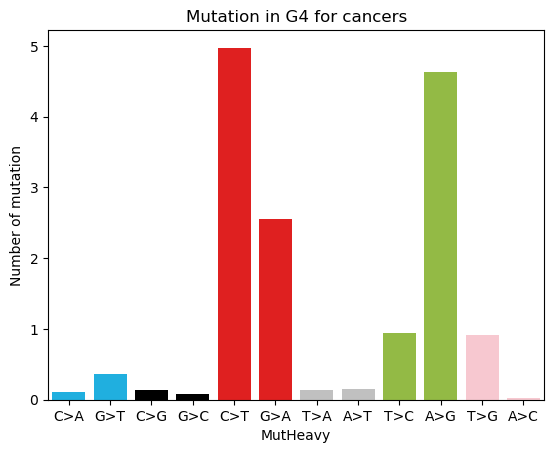

In [85]:
sns.barplot(data=obsMutG4.mean().reset_index(), x='index', y=0, order=sbs12_ordered, palette=color_mapping12) \
    .set(title='Mutation in G4 for cancers', xlabel='MutHeavy', ylabel='Number of mutation')

### Observed number of mutation around G4 :

In [58]:
Mut = []
for start, end in zip(df['window_start'], df['window_end']):
    row = [*range(start, end)]
    Mut.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))

In [59]:
# Mut

In [60]:
# w = [27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
# w2 = [378, 379, 380, 381, 382, 383, 384, 385, 386, 387]

In [61]:
# df_cansers[df_cansers['Pos'].isin(w2)].Mut.item()

In [62]:
Mut_df = pd.DataFrame(Mut)

In [63]:
Mut_df[0]

0       ['A[T>C]C' 'G[A>G]T' 'C[G>A]A']
1       ['A[T>C]C' 'G[A>G]T' 'C[G>A]A']
2       ['A[T>C]C' 'G[A>G]T' 'C[G>A]A']
3       ['A[T>C]C' 'G[A>G]T' 'C[G>A]A']
4       ['A[T>C]C' 'G[A>G]T' 'C[G>A]A']
                     ...               
3036                        ['G[G>A]G']
3037                        ['G[G>A]G']
3038                        ['G[G>A]G']
3039                        ['G[G>A]G']
3040              ['G[G>A]G' 'G[C>T]T']
Name: 0, Length: 3041, dtype: object

In [64]:
Mut_df[0] = Mut_df[0].str.findall("[A-T]>[A-T]")

In [65]:
obsMut = pd.DataFrame.from_records(Mut_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [66]:
obsMut

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3036,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3037,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3038,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3039,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Observed number of mutation around G4 (plot):

In [67]:
obsMut.columns = obsMut.columns.str.translate(complementator)

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Mutation around G4 for cancers'),
 Text(0.5, 0, 'MutHeavy'),
 Text(0, 0.5, 'Number of mutation')]

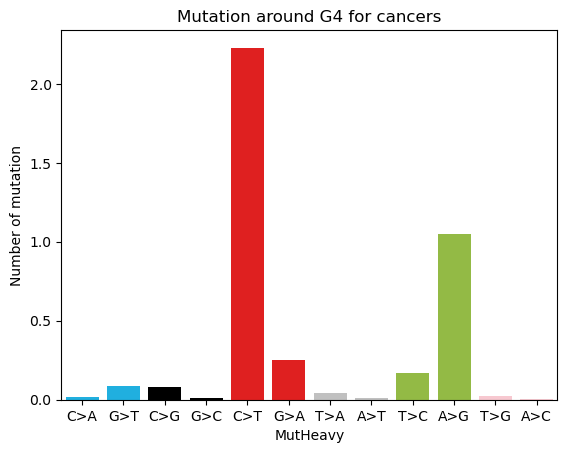

In [68]:
sns.barplot(data=obsMut.mean().reset_index(), x='index', y=0, order=sbs12_ordered, palette=color_mapping12) \
    .set(title='Mutation around G4 for cancers', xlabel='MutHeavy', ylabel='Number of mutation')

### Normalized mutspec for each window (no need yet):

In [69]:
# obsMut.columns

In [70]:
# normMut = pd.DataFrame()

# normMut[['A>C','A>G','A>T']] = obsMut[['A>C','A>G','A>T']].div(df['A'], axis=0)
# normMut[['C>A','C>G','C>T']] = obsMut[['C>A','C>G','C>T']].div(df['C'], axis=0)
# normMut[['G>A', 'G>C', 'G>T']] = obsMut[['G>A', 'G>C', 'G>T']].div(df['G'], axis=0)
# normMut[['T>A', 'T>C', 'T>G']] = obsMut[['T>A', 'T>C', 'T>G']].div(df['T'], axis=0)

In [71]:
# normMut = normMut.fillna(0)

In [72]:
# normMut = normMut.div(normMut.sum(axis=1), axis=0)

In [95]:
# obsMut.rolling(window=10, step=40).mean()[:39]

### Distribution of the number of mutations by position

In [99]:
g4conf[['G4_id', 'start', 'end']]

,G4_id,start,end
1,1,285,332
2,2,348,378
3,3,418,592
5,4,785,808
6,5,954,984
...,...,...,...
88,70,15636,15683
90,71,16167,16211
91,72,16239,16301
92,73,16344,16382


In [100]:
positions_G4 = []
count_mut_G4 = []

for start, end in zip(g4conf['start'], g4conf['end']):
    row = [*range(start, end)]
    for i in row:
        positions_G4.append(i)
        count_mut_G4.append(df_cancers[df_cancers['Pos'] == i].Mut.count())

In [101]:
positions_other = df_cancers[~df_cancers['Pos'].isin(positions_G4)].Pos.unique().tolist()

In [102]:
positions_other = sorted(positions_other)

In [103]:
count_mut_other = []
for i in positions_other:
    count_mut_other.append(df_cancers[df_cancers['Pos'] == i].Mut.count())

In [105]:
positions_all = positions_G4 + positions_other 

In [106]:
positions_nomut = ref_annot[~ref_annot['Pos'].isin(positions_all)].Pos.unique().tolist()

In [107]:
count_nomut = len(positions_nomut) * [0]

In [108]:
positions_all = positions_G4 + positions_other + positions_nomut

In [109]:
count_mut_all = count_mut_G4 + count_mut_other + count_nomut

In [110]:
df_mut_count = pd.DataFrame()
df_mut_count['Pos'] = positions_all
df_mut_count['count_mut'] = count_mut_all

In [111]:
df_mut_count.isna().sum()

Pos          0
count_mut    0
dtype: int64

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

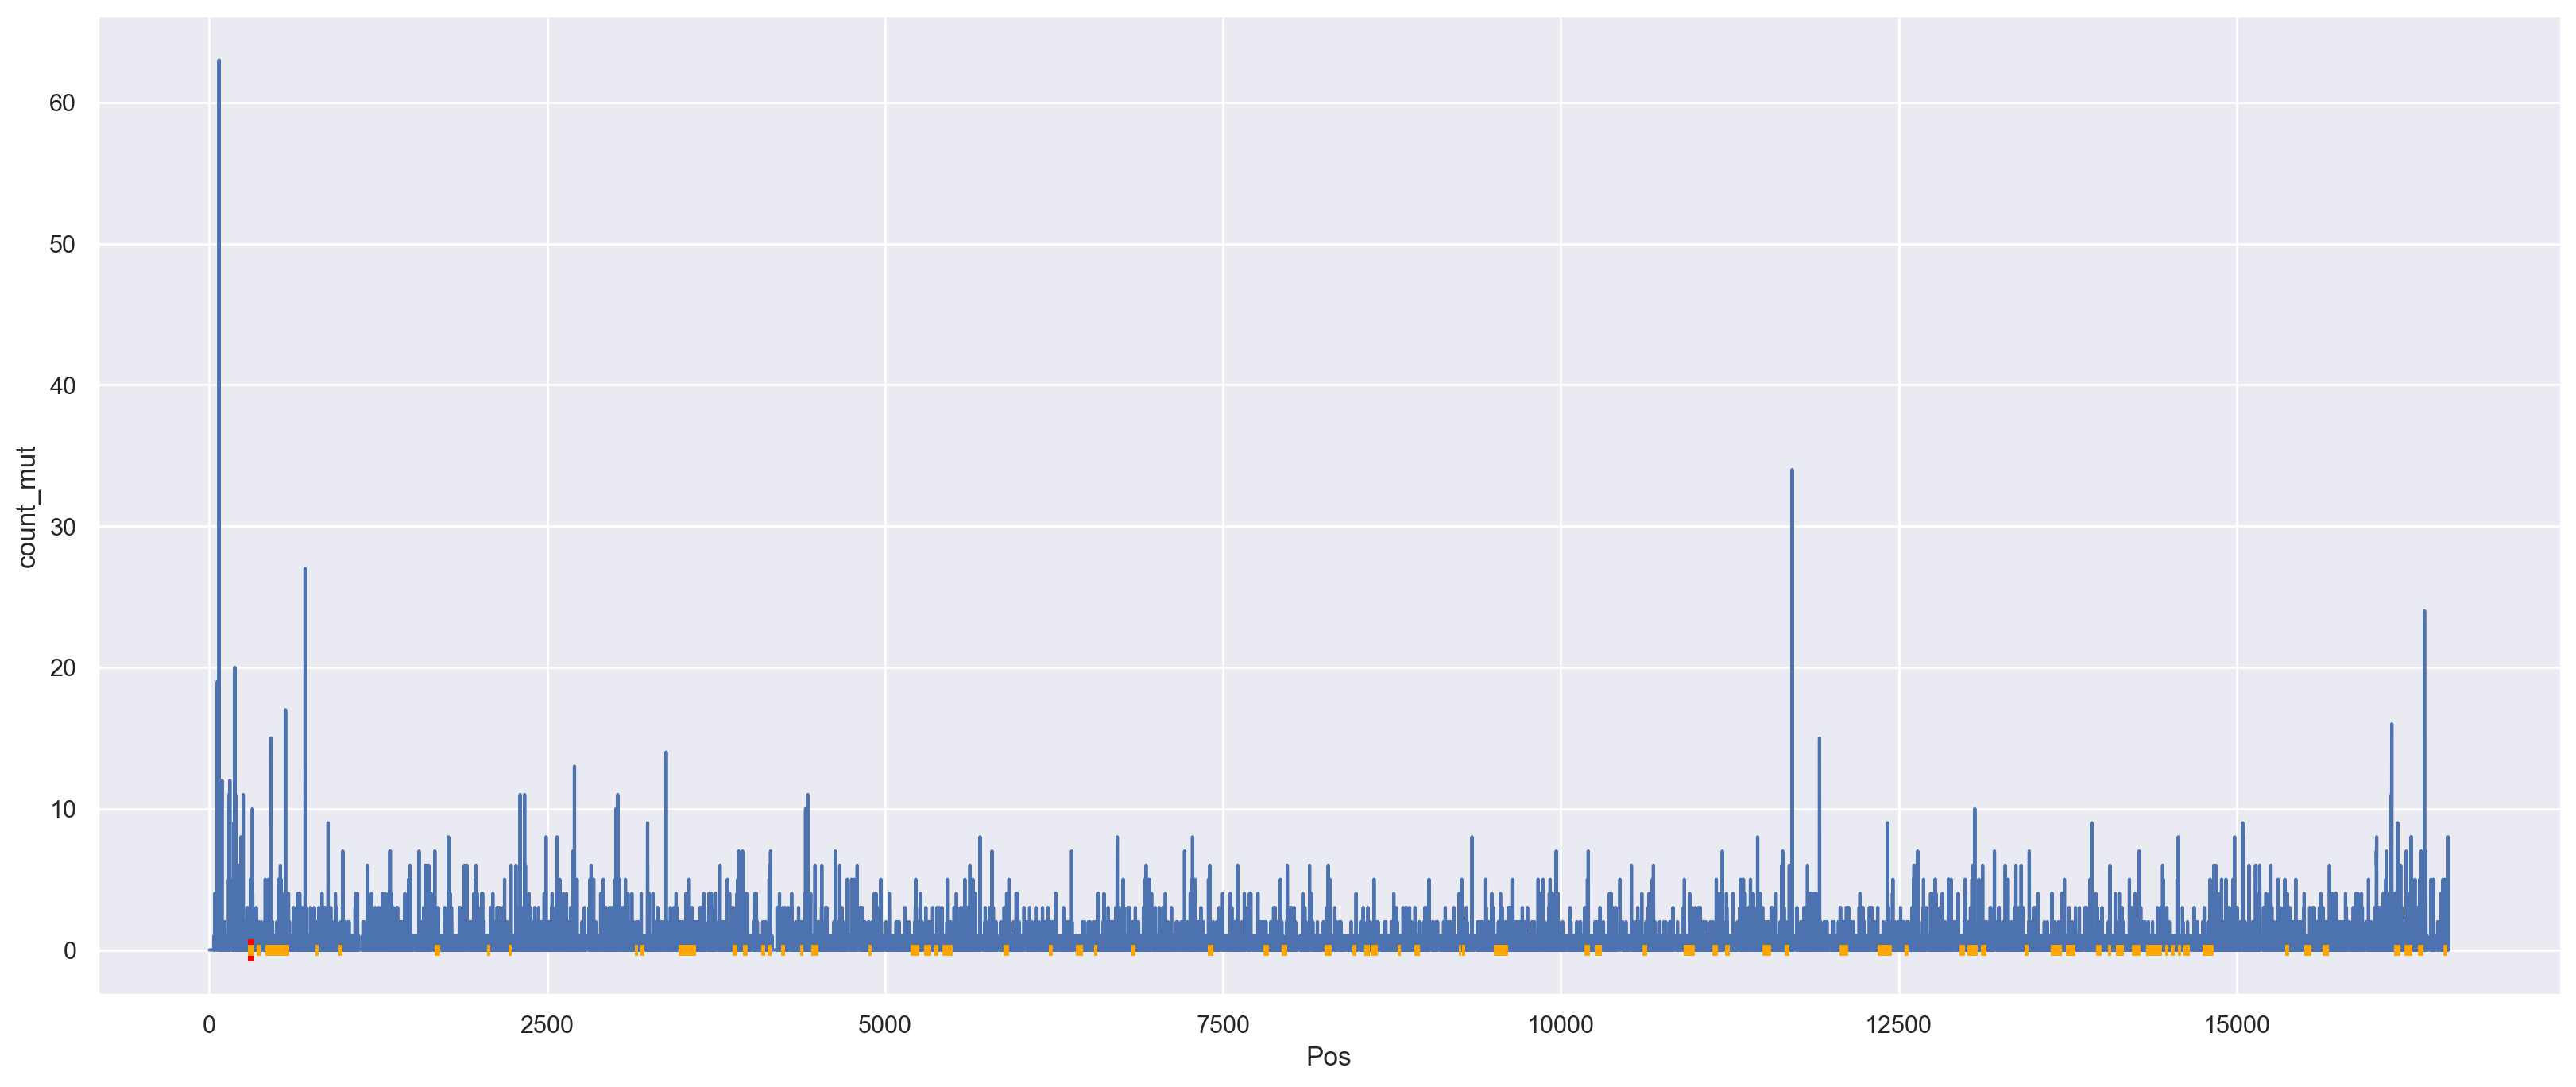

In [306]:
plt.figure(figsize=(20,8), dpi= 200, facecolor='w', edgecolor='k')
g = sns.lineplot(data=df_mut_count, x=df_mut_count['Pos'], y=df_mut_count['count_mut'])
g.hlines(y=0, xmin=285, xmax=332, color='red', linewidth=10.0)
# plt.axvline(x=285, color='red')


for xmin, xmax in zip(g4conf['start'], g4conf['end']):
    g.hlines(y=0, xmin=xmin, xmax=xmax, color='orange', linewidth=5.0)

**red** - G4-switch  
**orange** - other G4

### In G4-switch

In [112]:
q = df_mut_count[(df_mut_count['Pos'] < 400) & (df_mut_count['Pos'] > 200)]

In [122]:
q

,Pos,count_mut
0,285,0
1,286,0
2,287,0
3,288,0
4,289,0
...,...,...
7029,395,0
7030,396,0
7031,397,0
7032,398,0


In [164]:
qq = ref_annot[ref_annot['Pos'].isin(q['Pos'])].Nuc.str.translate(complementator).tolist()

In [172]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432,235,382,16,294,1
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478,298,428,40,16,2
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692,368,642,193,40,3
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908,735,858,146,193,4
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084,904,1034,683,146,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,1,UG4,more than africa,15536,15783,15586,15733,484,80,70
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,1,G4,more than africa,16067,16311,16117,16261,28,484,71
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,1,G4,more than africa,16139,16401,16189,16351,43,28,72
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,1,UG4,more than africa,16244,16482,16294,16432,145,43,73


C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

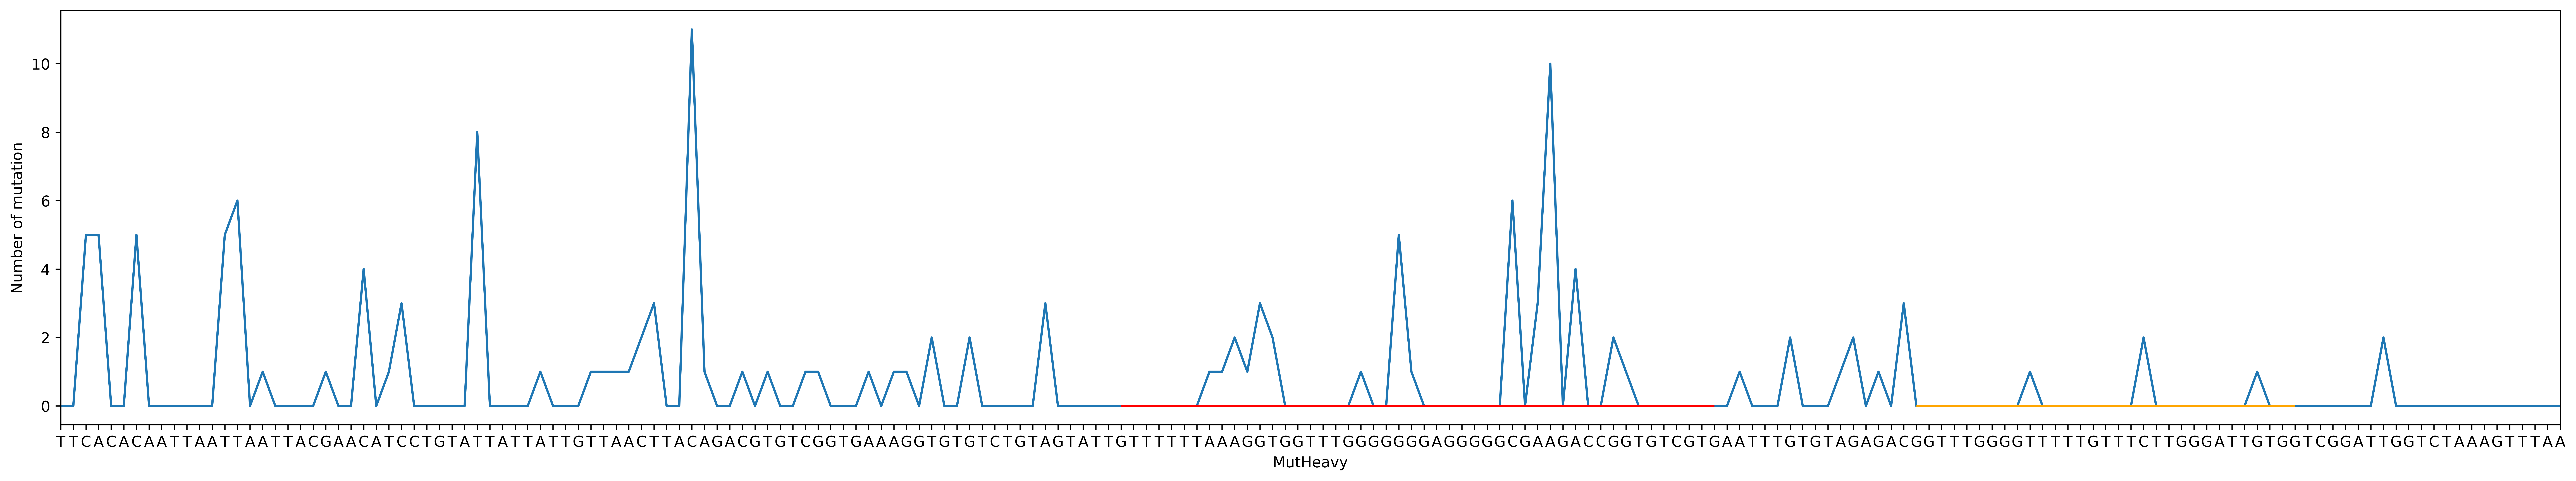

In [175]:
fig, ax = plt.subplots(figsize=(30, 5), dpi=600)
# fig.set_figwidth(40)

# ax.xaxis.set_major_formatter(format_fn)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))


g = sns.lineplot(data=q, x=q['Pos'], y=q['count_mut'])
g.hlines(y=0, xmin=285, xmax=332, color='red')
g.hlines(y=0, xmin=348, xmax=378, color='orange')

g.set(xlabel='MutHeavy', ylabel='Number of mutation')

plt.xticks(np.arange(min(q['Pos']), max(q['Pos'])+1, 1.0))
ax.set_xticklabels(qq)
ax.set_xlim([min(q['Pos']), max(q['Pos'])])


plt.show()

___

# Data preparation  
start here  
before we removing too much by sorting, thats why we change everything and start one more time  
step 2
## Step 2  
### New interval size:
- Take all confirmed G4   
- **Dont sort G4 by size between G4 >= 50 bp**  
- Obtain different interval size (0-100bp) between G4  

In [44]:
g4conf = pd.read_csv('g4conf.csv')

In [59]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,...,more than africa,185,432,235,382,16,294,1,185,348
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,...,less than africa,248,478,298,428,40,16,2,332,418
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,...,more than africa,15536,15783,15586,15733,484,80,70,15556,15783
70,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,...,more than africa,16067,16311,16117,16261,28,484,71,16067,16239
71,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,...,more than africa,16139,16401,16189,16351,43,28,72,16211,16344
72,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,...,more than africa,16244,16482,16294,16432,145,43,73,16301,16482


In [313]:
ref_annot.iloc[[3105, 3106, 3107, 3108, 3109, 3110]]

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
3105,3106,C,NaN,1,rRNA,RNR2,-1,-1,NaN,11339.0
3106,3107,NaN,NaN,1,misc_feature,RNR2,-1,-1,NaN,11341.0
3107,3108,T,NaN,1,rRNA,RNR2,-1,-1,NaN,11343.0
3108,3109,T,TTC,1,rRNA,RNR2,-1,-1,NaN,11345.0
3109,3110,C,TCA,1,rRNA,RNR2,-1,-1,NaN,11347.0
3110,3111,A,CAA,1,rRNA,RNR2,-1,-1,NaN,11349.0


In [312]:
ref_annot[ref_annot.Nuc.isna()]

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
3106,3107,NaN,NaN,1,misc_feature,RNR2,-1,-1,NaN,11341.0


In [108]:
# G4_id = 38 hasnt downstream windows
# G4_id = 39 hasnt upsteram windows

In [46]:
g4conf[(g4conf['G4_id'] == 38) | (g4conf['G4_id'] == 39)]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
37,"NC_012920.1 Homo sapiens mitochondrion, comple...",9243,9262,20,-,-1.65,-1.32,1,25,CCCAGCCCATGACCCCTAAC,...,less than africa,9143,9362,9193,9312,6,285,38,9143,9268
38,"NC_012920.1 Homo sapiens mitochondrion, comple...",9268,9293,26,-,-1.15,-1.12,1,25,CCCTCTCAGCCCTCCTAATGACCTCC,...,NaN,9168,9393,9218,9343,212,6,39,9262,9393


In [369]:
data_up = []

for up_win, start, G4_id in zip(g4conf['up_win'], g4conf['start'], g4conf['G4_id']):
    
    count_window = start - up_win - WINDOW_SIZE + 1  # count window in upstream interval (before G4)
    number_of_win = count_window + 1                 # reverse counting of windows; the closer to G4, the smaller the number
    
    for i in range(up_win, start):
        row = []
        
        if i+WINDOW_SIZE <= start:
            window = [*range(i, i + WINDOW_SIZE)]
        else:
            break
#         print(i, window)    
        window_seq = ''
        for pos in window:
            if pos != 3107:
                window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
            else:
                window_seq += ''
#         print(pos, window_seq)

#       ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()
        
        number_of_win -= 1
        
        row.append(G4_id)
        row.append('up')
        row.append(number_of_win)
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_up.append(row)
# print(data_up)

In [370]:
# data_up[:100]

In [371]:
data_down = []

for end, down_win, G4_id in zip(g4conf['end'], g4conf['down_win'], g4conf['G4_id']):
    
    number_of_win = 0
    
    for i in range(end, down_win):
        row = []
        
        if i >= g4conf['end'].iloc[-1] | i <= ref_annot['Pos'].iloc[-1]:
            window = [*range(i, ref_annot['Pos'].iloc[-1]+1)]
            remain = WINDOW_SIZE - (ref_annot['Pos'].iloc[-1] - i)
            window += [*range(ref_annot['Pos'].iloc[0], remain)]
        
        elif i > ref_annot['Pos'].iloc[-1] and i <= down_win - WINDOW_SIZE :
            i = i - ref_annot['Pos'].iloc[-1]
            window = [*range(i, i + WINDOW_SIZE)]
        
        elif i+WINDOW_SIZE < down_win:
            window = [*range(i, i + WINDOW_SIZE)]
               
        else:
            break
            
        window_seq = ''
        for pos in window:
            window_seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
#         print(window[0], window_seq)

#     ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()

        number_of_win += 1

        row.append(G4_id)
        row.append('down')
        row.append(number_of_win)
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_down.append(row)
# print(data_down)

In [372]:
data = data_up + data_down

In [373]:
# data[:10]

In [424]:
df_win = pd.DataFrame(data=data, columns = ['G4_id', 'side', 'number_of_win', 'window_start', 'window_end', 'sequence'])

In [425]:
df_win

,G4_id,side,number_of_win,window_start,window_end,sequence
0,1,up,91,185,194,GCGAACATAC
1,1,up,90,186,195,CGAACATACT
2,1,up,89,187,196,GAACATACTT
3,1,up,88,188,197,AACATACTTA
4,1,up,87,189,198,ACATACTTAC
...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC
9508,74,down,88,78,87,CGCGATAGCA
9509,74,down,89,79,88,GCGATAGCAT
9510,74,down,90,80,89,CGATAGCATT


In [426]:
df_win[df_win['side']=='down'].groupby(['G4_id']).agg({'number_of_win':'count'}).loc[70]

number_of_win    90
Name: 70, dtype: int64

In [427]:
df_win[df_win['side']=='down'].iloc[4636]

G4_id                    74
side                   down
number_of_win             8
window_start          16567
window_end                7
sequence         ATGGATCACA
Name: 9428, dtype: object

In [428]:
nuc_count_win = df_win['sequence'].apply(lambda x: Counter(x))

In [429]:
nuc_count_df_win = pd.DataFrame.from_records(nuc_count_win).sort_index(axis=1)

In [430]:
df_win = df_win.join(nuc_count_df_win).fillna(0)

### Finished dataset with nucleotide frequencies in windows 

In [431]:
df_win

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0


In [432]:
# df_win.to_csv('df_win.csv', index=False)

### Observed mutations Cancer dataset:   
Add mutations from Cancer dataset:

In [196]:
df_cancers = pd.read_csv('mutations.csv')

In [387]:
Mut_win = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))

In [388]:
Mut_win_df = pd.DataFrame(Mut_win)

In [389]:
Mut_win_df.head()

,0
0,['A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>...
1,['A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>...
2,['A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>...
3,['A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>...
4,['A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>G]C' 'A[A>...


In [390]:
Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")

In [391]:
Mut_win_df[0].head()

0    [A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, ...
1    [A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, ...
2    [A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, ...
3    [A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, ...
4    [A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, A>G, ...
Name: 0, dtype: object

In [392]:
obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [393]:
obsMutwin.head()

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,0.0,20.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,20.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0
3,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0
4,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0


In [394]:
obsMutwin.shape

(9512, 12)

In [396]:
df_win_cancer = df_win.join(obsMutwin)

In [398]:
df_win_cancer['number_of_Mut'] = df_win_cancer[['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']].sum(axis=1)

In [399]:
df_win_cancer[['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,0.0,20.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,20.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0
3,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0
4,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9507,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
9508,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
9509,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
9510,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [400]:
df_win_cancer[['A>G','C>T','G>A','T>C']].sum(axis=1)

0       24.0
1       25.0
2       32.0
3       32.0
4       32.0
        ... 
9507     2.0
9508     2.0
9509     2.0
9510     2.0
9511     0.0
Length: 9512, dtype: float64

In [401]:
df_win_cancer[['A>C','A>T','C>A','C>G','G>C','G>T','T>A','T>G']].sum(axis=1)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9507    1.0
9508    1.0
9509    1.0
9510    1.0
9511    1.0
Length: 9512, dtype: float64

### Finished dataset with observed mutations from cancer_df:

In [402]:
df_win_cancer

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


In [404]:
# df_win_cancer.to_csv('df_win_cancer.csv', index=False)

## Cancer win analysis

In [405]:
df_win_cancer = pd.read_csv('df_win_cancer.csv')

In [406]:
df_win_cancer

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


In [10]:
# sns.lineplot(data=df_win[df_win['side']=='up'], x=-df_win['number_of_win'], y='number_of_Mut', hue='G4_id')\
#     .set(title='From upstream to start G4')

In [11]:
# sns.lineplot(data=df_win[df_win['side']=='down'], x='number_of_win', y='number_of_Mut', hue='G4_id')\
#     .set(title='From end G4 to downstream')

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

[Text(0.5, 1.0, 'Number of mutation around G4')]

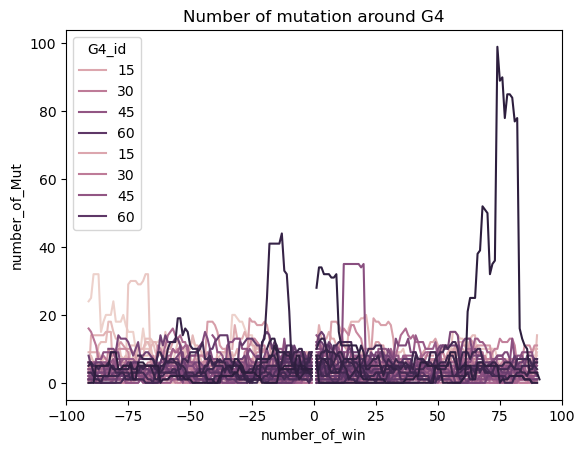

In [113]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='up'], x=-df_win_cancer['number_of_win'], y='number_of_Mut', hue='G4_id')
sns.lineplot(data=df_win[df_win_cancer['side']=='down'], x='number_of_win', y='number_of_Mut', hue='G4_id')\
    .set(title='Number of mutation around G4')

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

[Text(0.5, 1.0, 'Number of mutation around G4')]

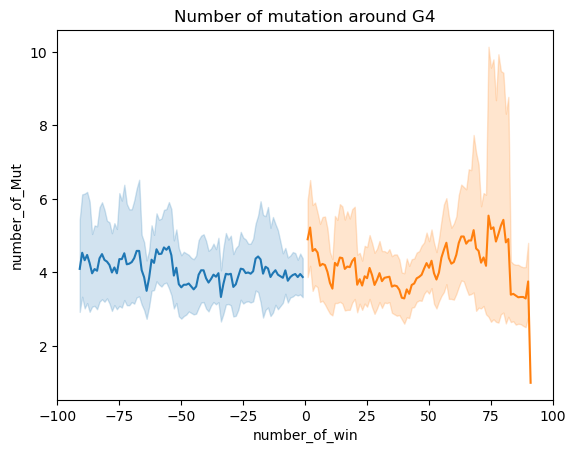

In [114]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='up'], x=-df_win_cancer['number_of_win'], y='number_of_Mut')
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='down'], x='number_of_win', y='number_of_Mut')\
    .set(title='Number of mutation around G4')

In [408]:
df_win_cancer[['G4_id', 'side', 'number_of_win', 'number_of_Mut']].sort_values(by=['G4_id', 'side','number_of_win'])

,G4_id,side,number_of_win,number_of_Mut
4792,1,down,1,3.0
4793,1,down,2,3.0
4794,1,down,3,4.0
4795,1,down,4,5.0
4796,1,down,5,5.0
...,...,...,...,...
4705,74,up,87,5.0
4704,74,up,88,5.0
4703,74,up,89,0.0
4702,74,up,90,0.0


## Compare upstream and downstream windows separately

In [28]:
df_sort_up = df_win_cancer[(df_win_cancer['side'] == 'up')][['G4_id', 'number_of_win', 'number_of_Mut']].sort_values(by=['G4_id','number_of_win'])

In [29]:
df_sort_down = df_win_cancer[(df_win_cancer['side'] == 'down')][['G4_id', 'number_of_win', 'number_of_Mut']].sort_values(by=['G4_id','number_of_win'])

In [30]:
bins_up = []
for G4_id in df_sort_up['G4_id'].unique():
    bins_up.append(df_sort_up[(df_sort_up['G4_id'] == G4_id)]['number_of_Mut'].values)
# print(bins_up)

In [31]:
bins_down = []
for G4_id in df_sort_down['G4_id'].unique():
    bins_down.append(df_sort_down[(df_sort_down['G4_id'] == G4_id)]['number_of_Mut'].values)
# print(bins_down)

In [32]:
def histogram_intersection(hist1: np.ndarray, hist2: np.ndarray):
    return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)

In [33]:
def df_intersection(lst_of_ndarray, df_sort_by_G4_id):
    lst = []
    for i in range(len(lst_of_ndarray)):
        
        j = 0

        while j < len(lst_of_ndarray):
            row = []
            if len(lst_of_ndarray[i]) > len(lst_of_ndarray[j]):
                length = len(lst_of_ndarray[j])

                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i][:length], lst_of_ndarray[j]))
                lst.append(row)
            elif len(lst_of_ndarray[i]) < len(lst_of_ndarray[j]):
                length = len(lst_of_ndarray[i])

                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i], lst_of_ndarray[j][:length]))
                lst.append(row)
            else:
                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i], lst_of_ndarray[j]))
            
                lst.append(row)
            j += 1
    
    df = pd.DataFrame(lst, columns=['G4_id_1', 'G4_id_2', 'intersection'])
    df['G4_id_1'] = np.repeat(df_sort_by_G4_id['G4_id'].unique(), len(lst_of_ndarray)).tolist()
    df['G4_id_2'] = df_sort_by_G4_id['G4_id'].unique().tolist()*len(lst_of_ndarray)
    
    return df

In [34]:
df_i_up = df_intersection(bins_up, df_sort_up)

C:\Users\777\AppData\Local\Temp\ipykernel_18400\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


In [35]:
df_i_down = df_intersection(bins_down, df_sort_down)

C:\Users\777\AppData\Local\Temp\ipykernel_18400\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

[Text(0.5, 1.0, 'Downstream')]

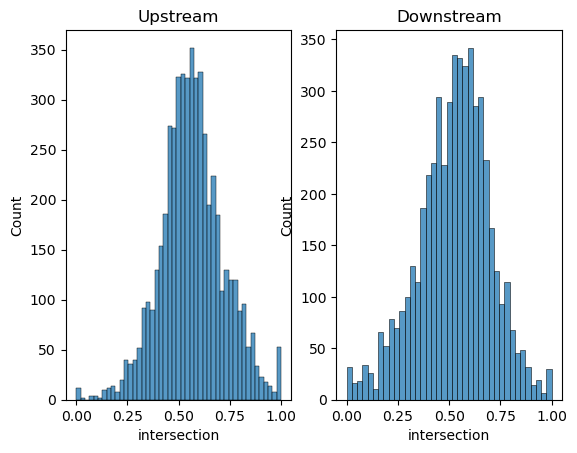

In [36]:
fig, axs = plt.subplots(ncols=2)
sns.histplot(df_i_up['intersection'], ax=axs[0]).set(title='Upstream')
sns.histplot(df_i_down['intersection'], ax=axs[1]).set(title='Downstream')

In [37]:
df_i_up.pivot(index='G4_id_1', columns='G4_id_2', values='intersection')

G4_id_2,1,2,3,4,5,6,7,8,9,10,...,65,66,67,68,69,70,71,72,73,74
G4_id_1,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.848073,0.330748,0.536355,0.564563,0.542014,0.683379,0.518583,0.604348,0.822970,...,0.636260,0.801732,0.389044,0.530201,0.509754,0.635042,0.473984,0.742771,0.703148,0.393490
2,0.848073,1.000000,0.850454,0.781840,0.776557,0.779592,0.538776,0.872222,0.777211,0.823810,...,0.839105,0.837084,0.452381,0.850454,0.922160,0.654710,0.722222,0.713719,0.846825,0.781241
3,0.330748,0.850454,0.709677,0.508145,0.412386,0.350378,0.435749,0.524497,0.400691,0.749290,...,0.624775,0.867653,0.455970,0.495222,0.485177,0.372395,0.347778,0.348638,0.446215,0.479228
4,0.536355,0.781840,0.508145,1.000000,0.627340,0.550913,0.609257,0.714719,0.541499,0.787013,...,0.729742,0.875263,0.507287,0.586367,0.670940,0.650396,0.512581,0.481161,0.692633,0.514378
5,0.564563,0.776557,0.412386,0.627340,1.000000,0.566706,0.599856,0.605643,0.628891,0.708596,...,0.527999,0.821716,0.471857,0.595803,0.629863,0.764691,0.589828,0.776935,0.668870,0.474453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.635042,0.654710,0.372395,0.650396,0.764691,0.638959,0.665248,0.657355,0.630171,0.696763,...,0.538510,0.699817,0.545087,0.538666,0.709439,0.985915,0.567437,0.741492,0.716211,0.483012
71,0.473984,0.722222,0.347778,0.512581,0.589828,0.542838,0.532793,0.593493,0.537713,0.734704,...,0.400944,0.713997,0.359237,0.531780,0.552110,0.567437,0.956044,0.617277,0.586693,0.436041
72,0.742771,0.713719,0.348638,0.481161,0.776935,0.434278,0.527865,0.484104,0.762525,0.724190,...,0.466536,0.618553,0.432995,0.553642,0.662499,0.741492,0.617277,1.000000,0.769191,0.526072


<Axes: xlabel='G4_id_2', ylabel='G4_id_1'>

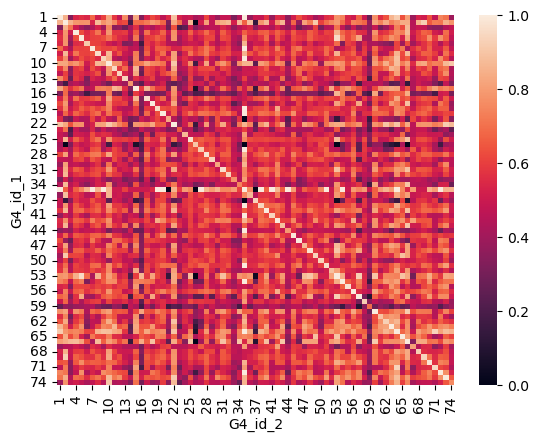

In [38]:
sns.heatmap(df_i_up.pivot(index='G4_id_1', columns='G4_id_2', values='intersection'))

<Axes: xlabel='G4_id_2', ylabel='G4_id_1'>

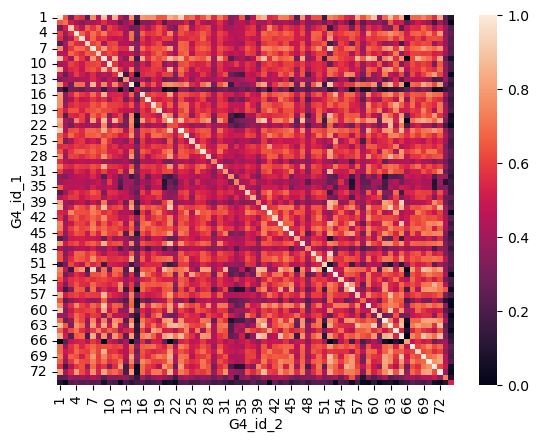

In [39]:
sns.heatmap(df_i_down.pivot(index='G4_id_1', columns='G4_id_2', values='intersection'))

Text(0.5, 0.98, 'Upstream intervals')

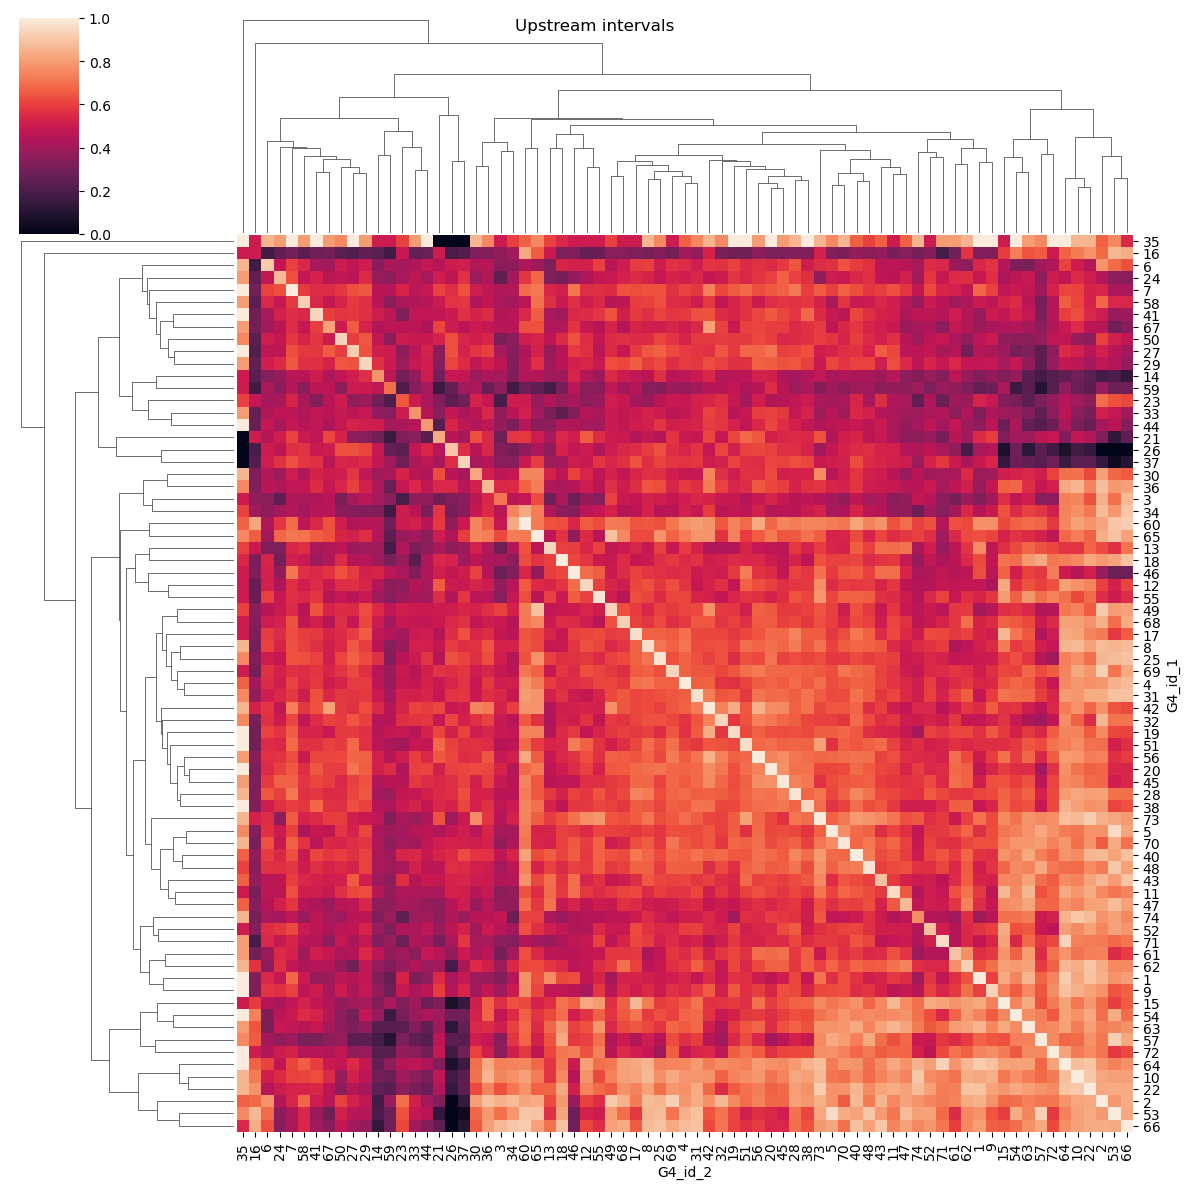

In [40]:
sns.clustermap(df_i_up.pivot(index='G4_id_1', columns='G4_id_2', values='intersection'),figsize=(12, 12),
               xticklabels=True, yticklabels=True) \
    .fig.suptitle('Upstream intervals')

Text(0.5, 0.98, 'Downstream intervals')

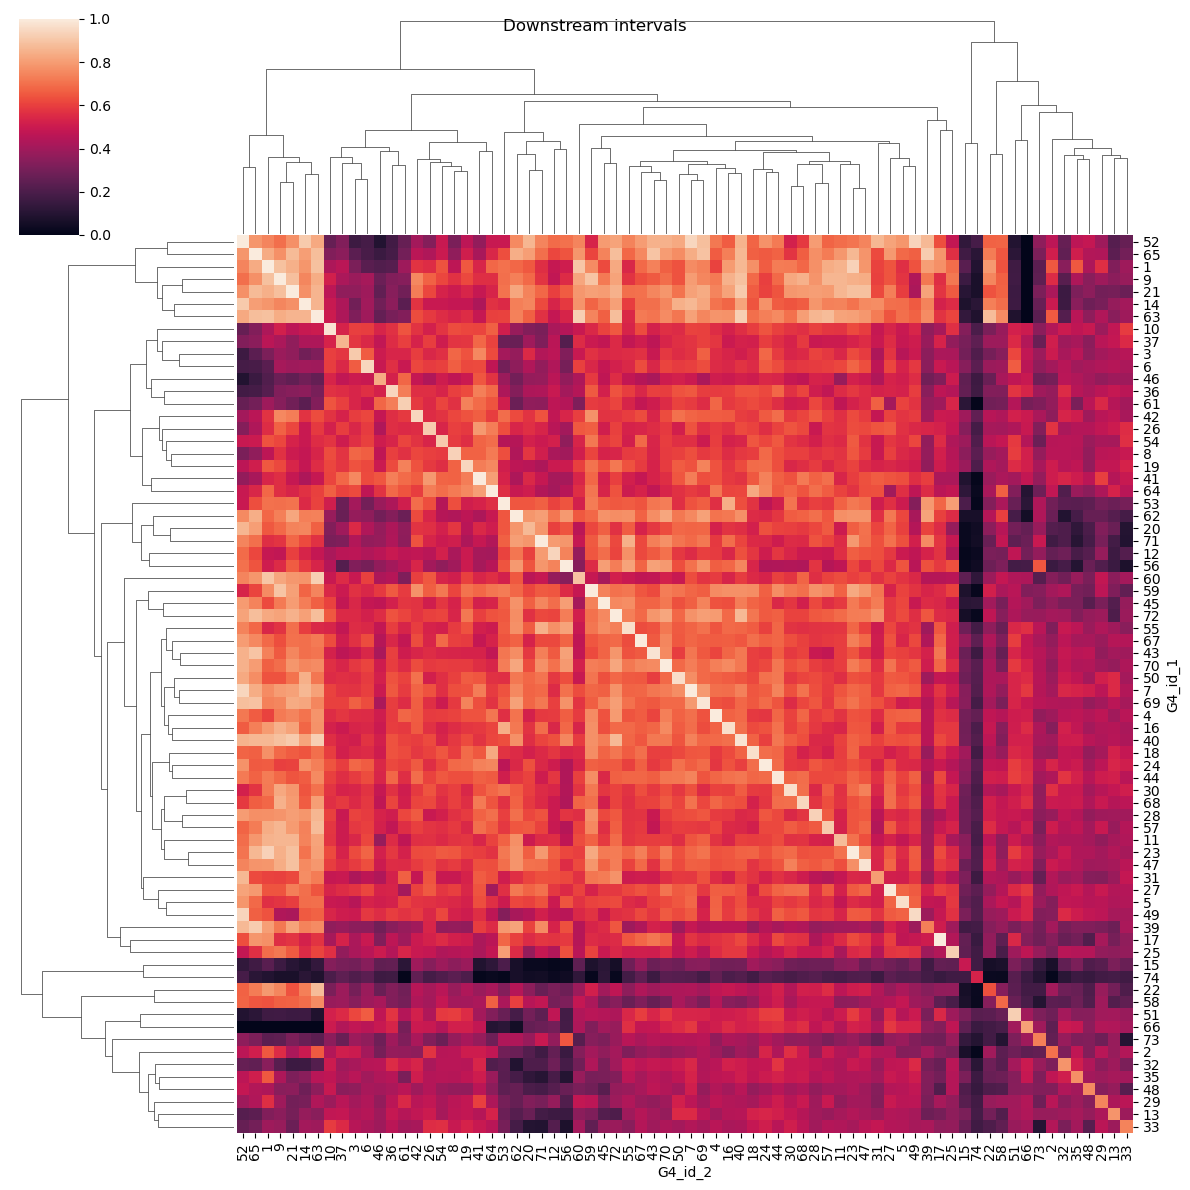

In [41]:
sns.clustermap(df_i_down.pivot(index='G4_id_1', columns='G4_id_2', values='intersection'), figsize=(12, 12),
               xticklabels=True, yticklabels=True) \
    .fig.suptitle('Downstream intervals')

#### We have outgroups:  
- Upstream: 35, 16; 14, 59, 23, 33, 44, 21, 26, 37  
- Downstream: 15, 74; 22, 58, 51, 66, 73, 2, 32, 35, 48, 29, 13, 33

In [52]:
outgroup_up = [35, 16, 14, 59, 23, 33, 44, 21, 26, 37]
outgroup_down = [15, 74, 22, 58, 51, 66, 73, 2, 32, 35, 48, 29, 13, 33]

In [407]:
df_win_cancer

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


In [45]:
g4conf = pd.read_csv('g4conf.csv')

In [57]:
# upstream
g4conf[(g4conf['G4_id'].isin(outgroup_up)) & (g4conf['bp_untill_previous_G4'] >= 100)]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
13,"NC_012920.1 Homo sapiens mitochondrion, comple...",4086,4111,26,-,-1.080,-1.08,1,25,CACCAAGACCCTACTTCTAACCTCCC,...,NaN,3986,4211,4036,4161,19,102,14,3986,4130
25,"NC_012920.1 Homo sapiens mitochondrion, comple...",6410,6464,55,-,-1.050,-1.44,1,25,CAATATAAAACCCCCTGCCATAACCCAATACCAAACGCCCCTCTTC...,...,more than africa,6310,6564,6360,6514,81,168,26,6310,6545
32,"NC_012920.1 Homo sapiens mitochondrion, comple...",8455,8488,34,-,-1.090,-1.36,1,25,CACAAACTACCACCTACCTCCCTCACCAAAGCCC,...,NaN,8355,8588,8405,8538,56,150,33,8355,8544
36,"NC_012920.1 Homo sapiens mitochondrion, comple...",8917,8958,42,-,-0.881,-1.56,1,25,CAAGGCACACCTACACCCCTTATCCCCATACTAGTTATTATC,...,more than africa,8817,9058,8867,9008,285,102,37,8817,9058
43,"NC_012920.1 Homo sapiens mitochondrion, comple...",10912,10990,79,-,-1.330,-2.08,1,25,CTGTTCCCCAACCTTTTCCTCCGACCCCCTAACAACCCCCCTCCTA...,...,2 g4 in africa,10812,11090,10862,11040,132,275,44,10812,11090


In [58]:
# downstream
g4conf[(g4conf['G4_id'].isin(outgroup_down)) & (g4conf['bp_untill_previous_G4'] >= 100)]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
28,"NC_012920.1 Homo sapiens mitochondrion, comple...",7386,7427,42,-,-1.020,-1.56,1,25,CTATATGGATGCCCCCCACCCTACCACACATTCGAAGAACCC,...,more than africa,7286,7527,7336,7477,371,535,29,7286,7527
31,"NC_012920.1 Homo sapiens mitochondrion, comple...",8252,8305,54,-,-1.220,-2.00,1,25,CCCGTATTTACCCTATAGCACCCCCTCTACCCCCTCTAGAGCCCAC...,...,more than africa,8152,8405,8202,8355,150,278,32,8152,8405
32,"NC_012920.1 Homo sapiens mitochondrion, comple...",8455,8488,34,-,-1.090,-1.36,1,25,CACAAACTACCACCTACCTCCCTCACCAAAGCCC,...,NaN,8355,8588,8405,8538,56,150,33,8355,8544
47,"NC_012920.1 Homo sapiens mitochondrion, comple...",11655,11692,38,-,-0.816,-1.20,1,25,CAGCCATTCTCATCCAAACCCCCTGAAGCTTCACCGGC,...,more than africa,11555,11792,11605,11742,371,100,48,11555,11792
57,"NC_012920.1 Homo sapiens mitochondrion, comple...",13959,14004,46,-,-0.935,-1.28,1,25,CCTTCTTACGAGCCAAAACCTGCCCCTACTCCTCCTAGACCTAACC,...,more than africa,13859,14104,13909,14054,45,150,58,13859,14049
73,"NC_012920.1 Homo sapiens mitochondrion, comple...",16527,16560,34,-,-0.853,-1.16,1,25,CCTAAATAGCCCACACGTTCCCCTTAAATAAGAC,...,more than africa,16427,91,16477,16610,294,145,74,16427,16660


# Data preparation for Human Global Tree

In [8]:
df_hgt = pd.read_table('fulltreeCodons.csv', sep=';')

In [9]:
df_hgt

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,synonymous,ancestral_aa,derived_aa,note,ancestral_codon,derived_codon
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding,NaN,NaN
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding,NaN,NaN
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,3.0,synonymous,Leu,Leu,normal,ctA,ctG
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,1.0,non-synonymous,Val,Ambiguous,normal,Gtc,Rtc
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,2.0,non-synonymous,Pro,Ambiguous,normal,cCa,cMa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577271,27068,EU_DK_0660,12579,12339,taGcc,taAcc,A,mRNA_ND5,12336.0,1.0,non-synonymous,Ala,Thr,normal,Gcc,Acc
577272,27068,EU_DK_0660,12597,12357,taGcc,taAcc,A,mRNA_ND5,12336.0,1.0,non-synonymous,Ala,Thr,normal,Gcc,Acc
577273,27068,EU_DK_0660,13191,12949,aaGcg,aaAcg,A,mRNA_ND5,12336.0,2.0,non-synonymous,Ser,Asn,normal,aGc,aAc
577274,27068,EU_DK_0660,15612,15366,aaCcc,aaTcc,C,mRNA_CYTB,14746.0,3.0,synonymous,Asn,Asn,normal,aaC,aaT


In [10]:
df_hgt[['ref_pos', 'nuc_ref_in_ali']].sort_values(by='ref_pos').drop_duplicates(subset=['ref_pos'])

,ref_pos,nuc_ref_in_ali
180102,1,A
145345,2,T
23128,3,C
241539,4,A
115232,5,C
...,...,...
319935,16564,C
218409,16565,G
100890,16566,A
466991,16567,T


In [11]:
#  ''.join(df_hgt[['ref_pos', 'nuc_ref_in_ali']].sort_values(by='ref_pos').drop_duplicates(subset=['ref_pos'])['nuc_ref_in_ali'].values.tolist())

In [12]:
df_unique = df_hgt[['ref_pos', 'nuc_ref_in_ali']].sort_values(by='ref_pos').drop_duplicates(subset=['ref_pos'])

In [13]:
seq = ''.join(pd.DataFrame([*range(1, 16569)], [*range(1, 16569)]).join(df_unique.set_index('ref_pos')).fillna('N')['nuc_ref_in_ali'].values.tolist())

In [14]:
len(seq)

16568

In [15]:
seq.count('-')

43

In [16]:
seq = seq.replace('-', '')

In [17]:
# seq_hgt_ref = open(r'seq_hgt_ref.fasta', 'w+')

In [18]:
# seq_hgt_ref.write(''.join('>hgt_ref' + '\n' + seq))

In [19]:
# seq_hgt_ref.close()

In [20]:
with open('hgt.blast') as fin:
    while True:
        line = fin.readline()
        if 'Strand=Plus/Plus' in line:
            fin.readline()
            break
    qseq = ''
    rods = ''
    sseq = ''
    query, sbjct = 'Query', 'Sbjct'
    i = 0
    size = 60
    start = 14
    while query.startswith('Query') and sbjct.startswith('Sbjct'):
        i += 1
        query = fin.readline().strip()
        cur_rods = fin.readline()
        sbjct = fin.readline().strip()

        if len(query[start:start+size]) == size:
            qseq += query[start:start+size]
            sseq += sbjct[start:start+size]
            rods += cur_rods[start:start+size]
        else:
            pos = re.search('Query\s{2}(\d+)\s+[\w-]+\s+(\d+)', query).groups()
            size = int(pos[1]) - int(pos[0]) + 1
            
            qseq += query[start:start+size]
            sseq += sbjct[start:start+size]
            rods += cur_rods[start:start+size]
            break
            
        fin.readline()

In [21]:
print('sseq =', len(sseq), 'qseq =', len(qseq))

sseq = 16568 qseq = 16568


In [22]:
sseq = 'G' + sseq
qseq = 'G' + qseq

In [23]:
print('sseq =', len(sseq), 'qseq =', len(qseq))

sseq = 16569 qseq = 16569


In [24]:
dict_hgt = {i: qseq[i] for i in range(len(qseq))}

In [25]:
dict_ref = {i: sseq[i] for i in range(len(sseq))}

In [26]:
df_ali_hgt_to_ref = pd.DataFrame.from_dict(dict_ref, orient='index', columns=['nuc_ref']) \
    .reset_index() \
    .rename(columns={'index':'Pos'})

In [27]:
df_ali_hgt_to_ref['nuc_hgt'] = df_ali_hgt_to_ref['Pos'].map(dict_hgt)

In [28]:
df_ali_hgt_to_ref['Pos'] = range(1, len(df_ali_hgt_to_ref['Pos'])+1)

In [29]:
df_ali_hgt_to_ref

,Pos,nuc_ref,nuc_hgt
0,1,G,G
1,2,A,A
2,3,T,T
3,4,C,C
4,5,A,A
...,...,...,...
16564,16565,C,C
16565,16566,G,G
16566,16567,A,A
16567,16568,T,T


In [30]:
df_ali_hgt_to_ref['nuc_hgt'].value_counts()

nuc_hgt
N    4930
C    3982
A    3052
T    2747
G    1743
c      48
-      43
n      12
t       5
g       4
a       3
Name: count, dtype: int64

In [31]:
df_ali_hgt_to_ref = df_ali_hgt_to_ref.replace({'c':'C', 'n':'N', 't':'T', 'g':'G', 'a':'A'})

In [32]:
df_ali_hgt_to_ref['nuc_hgt'].value_counts()

nuc_hgt
N    4942
C    4030
A    3055
T    2752
G    1747
-      43
Name: count, dtype: int64

In [33]:
16569-4942

11627

In [34]:
df_unique.shape

(11627, 2)

In [35]:
df_unique['nuc_ref_in_ali'].value_counts()

nuc_ref_in_ali
C    4030
A    3055
T    2752
G    1746
-      43
N       1
Name: count, dtype: int64

In [36]:
df_unique = df_unique.reset_index(drop=True)

In [37]:
df_unique

,ref_pos,nuc_ref_in_ali
0,1,A
1,2,T
2,3,C
3,4,A
4,5,C
...,...,...
11622,16564,C
11623,16565,G
11624,16566,A
11625,16567,T


In [38]:
df_unique_sort = df_unique[~((df_unique['nuc_ref_in_ali'] == '-') | (df_unique['nuc_ref_in_ali'] == 'N'))][['ref_pos', 'nuc_ref_in_ali']]

In [39]:
df_unique_sort = df_unique_sort.reset_index(drop=True)

In [40]:
# Detele all posirions with N, -, and first position
a = df_ali_hgt_to_ref[~((df_ali_hgt_to_ref['nuc_hgt'] == 'N') | (df_ali_hgt_to_ref['nuc_hgt'] == '-') | (df_ali_hgt_to_ref['Pos'] == 1))].reset_index()

In [41]:
df_pos_ref_to_hgt = pd.concat([a, df_unique_sort], axis=1).rename(columns={'ref_pos':'hgt_ref_pos'}).set_index('index')

In [42]:
df_pos_ref_to_hgt.index.name = None

In [43]:
df_unique[df_unique['nuc_ref_in_ali'] == 'N']

,ref_pos,nuc_ref_in_ali
1983,3106,N


In [44]:
df_ali_hgt_to_ref[df_ali_hgt_to_ref['nuc_ref'] == 'N']

,Pos,nuc_ref,nuc_hgt
3106,3107,N,N


In [45]:
df_pos_ref_to_hgt

,Pos,nuc_ref,nuc_hgt,hgt_ref_pos,nuc_ref_in_ali
1,2,A,A,1,A
2,3,T,T,2,T
3,4,C,C,3,C
4,5,A,A,4,A
5,6,C,C,5,C
...,...,...,...,...,...
16564,16565,C,C,16564,C
16565,16566,G,G,16565,G
16566,16567,A,A,16566,A
16567,16568,T,T,16567,T


In [46]:
df_ali_hgt_to_ref = df_ali_hgt_to_ref.join(df_pos_ref_to_hgt, how='left', rsuffix='2') \
    .drop(columns=['Pos2', 'nuc_ref2', 'nuc_hgt2', 'nuc_hgt']) \
    .astype({'hgt_ref_pos':'Int64'})

Add position with N in hgt columns:

In [47]:
df_ali_hgt_to_ref.iloc[3106]

Pos               3107
nuc_ref              N
hgt_ref_pos       <NA>
nuc_ref_in_ali     NaN
Name: 3106, dtype: object

In [48]:
df_ali_hgt_to_ref.iloc[3106, df_ali_hgt_to_ref.columns.get_loc('hgt_ref_pos')] = 3106
df_ali_hgt_to_ref.iloc[3106, df_ali_hgt_to_ref.columns.get_loc('nuc_ref_in_ali')] = 'N'

In [49]:
df_ali_hgt_to_ref.iloc[3106]

Pos               3107
nuc_ref              N
hgt_ref_pos       3106
nuc_ref_in_ali       N
Name: 3106, dtype: object

In [50]:
# 4 mismatches
df_ali_hgt_to_ref[(df_ali_hgt_to_ref['nuc_ref'] != df_ali_hgt_to_ref['nuc_ref_in_ali']) & ((df_ali_hgt_to_ref['nuc_ref_in_ali'] == 'T') | (df_ali_hgt_to_ref['nuc_ref_in_ali'] == 'C'))]

,Pos,nuc_ref,hgt_ref_pos,nuc_ref_in_ali
55,56,A,57,T
959,960,C,960,T
8270,8271,A,8271,C
8275,8276,C,8276,T


### Add labels G4 to hgt (from g4conf to df_hgt_g4)

In [51]:
g4conf = pd.read_csv('g4conf.csv')

In [52]:
g4conf.head()

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.25,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,...,more than africa,185,432,235,382,16,294,1,185,348
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.10,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,...,less than africa,248,478,298,428,40,16,2,332,418
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.15,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.21,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.39,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084


In [53]:
df_ali_hgt_to_ref

,Pos,nuc_ref,hgt_ref_pos,nuc_ref_in_ali
0,1,G,<NA>,NaN
1,2,A,1,A
2,3,T,2,T
3,4,C,3,C
4,5,A,4,A
...,...,...,...,...
16564,16565,C,16564,C
16565,16566,G,16565,G
16566,16567,A,16566,A
16567,16568,T,16567,T


In [54]:
# df_ali_hgt_to_ref['G4_start'] = df_ali_hgt_to_ref['Pos'].isin(g4conf['start']).astype(int)

In [55]:
# df_ali_hgt_to_ref['G4_end'] = df_ali_hgt_to_ref['Pos'].isin(g4conf['end']).astype(int)

In [56]:
# df_ali_hgt_to_ref[(df_ali_hgt_to_ref['G4_start'] == 1) | (df_ali_hgt_to_ref['G4_end'] == 1)]

In [57]:
# df_ali_hgt_to_ref[((df_ali_hgt_to_ref['G4_start'] == 1) | (df_ali_hgt_to_ref['G4_end'] == 1)) & (df_ali_hgt_to_ref['hgt_ref_pos'].isna()) ]

In [96]:
for start, end, G4_id in zip(g4conf['start'], g4conf['end'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(start, end+1)]),'G4'] = 1
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(start, end+1)]),'G4_id'] = G4_id

In [97]:
for up_win, start, G4_id in zip(g4conf['up_win'], g4conf['start'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(up_win, start+1)]),'up_win'] = G4_id

In [98]:
for end, down_win, G4_id in zip(g4conf['end'], g4conf['down_win'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(end, down_win+1)]),'down_win'] = G4_id

In [99]:
df_ali_hgt_to_ref[['G4', 'G4_id', 'up_win', 'down_win']] = df_ali_hgt_to_ref[['G4',  'G4_id', 'up_win', 'down_win']].fillna(0)

In [100]:
df_ali_hgt_to_ref

,Pos,nuc_ref,hgt_ref_pos,nuc_ref_in_ali,G4,G4_id,up_win,down_win
0,1,G,<NA>,NaN,0.0,0.0,0.0,0.0
1,2,A,1,A,0.0,0.0,0.0,0.0
2,3,T,2,T,0.0,0.0,0.0,0.0
3,4,C,3,C,0.0,0.0,0.0,0.0
4,5,A,4,A,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
16564,16565,C,16564,C,0.0,0.0,0.0,74.0
16565,16566,G,16565,G,0.0,0.0,0.0,74.0
16566,16567,A,16566,A,0.0,0.0,0.0,74.0
16567,16568,T,16567,T,0.0,0.0,0.0,74.0


In [123]:
df_ali_hgt_to_ref[['hgt_ref_pos', 'Pos', 'G4_id', 'G4', 'up_win', 'down_win']].rename(columns={'hgt_ref_pos':'ref_pos'}).head()

,ref_pos,Pos,G4_id,G4,up_win,down_win
0,<NA>,1,0.0,0.0,0.0,0.0
1,1,2,0.0,0.0,0.0,0.0
2,2,3,0.0,0.0,0.0,0.0
3,3,4,0.0,0.0,0.0,0.0
4,4,5,0.0,0.0,0.0,0.0


In [102]:
df_hgt.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,synonymous,ancestral_aa,derived_aa,note,ancestral_codon,derived_codon
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding,NaN,NaN
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding,NaN,NaN
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,3.0,synonymous,Leu,Leu,normal,ctA,ctG
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,1.0,non-synonymous,Val,Ambiguous,normal,Gtc,Rtc
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,2.0,non-synonymous,Pro,Ambiguous,normal,cCa,cMa


In [124]:
df_hgt_g4 = df_hgt \
    .merge(df_ali_hgt_to_ref[['hgt_ref_pos', 'Pos', 'G4_id', 'G4', 'up_win', 'down_win']].rename(columns={'hgt_ref_pos':'ref_pos'}), how='left') \
    .sort_values(by='ref_pos')

In [125]:
df_hgt_g4['Mut'] = df_hgt_g4.ancestor.str[2] + '>' + df_hgt_g4.descendant.str[2]

In [126]:
df_hgt_g4.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,ancestral_codon,derived_codon,Pos,G4_id,G4,up_win,down_win,Mut
180102,6852,XX_XX_11096,2,1,g-Atc,--Gat,A,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,2.0,0.0,0.0,0.0,0.0,A>G
120165,6849,EU_IT_0232,2,1,--Gat,g-Atc,A,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,2.0,0.0,0.0,0.0,0.0,G>A
100485,6848,XX_XX_9138,2,1,--Gat,g-Atc,A,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,2.0,0.0,0.0,0.0,0.0,G>A
457015,6848,AM_US_0618,2,1,--Gat,g-Atc,A,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,2.0,0.0,0.0,0.0,0.0,G>A
175438,6852,AM_CO_0379,2,1,g-Atc,--Gat,A,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,2.0,0.0,0.0,0.0,0.0,A>G


In [127]:
# df_hgt_g4.to_csv('df_hgt_g4.csv', index=False)

### Collect observed mutations from HGT

In [145]:
df_hgt_g4 = pd.read_csv('df_hgt_g4.csv')

C:\Users\777\AppData\Local\Temp\ipykernel_7044\2646133863.py:1: DtypeWarning: Columns (10,11,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hgt_g4 = pd.read_csv('df_hgt_g4.csv')


In [197]:
df_hgt_g4.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,ancestral_codon,derived_codon,Pos,G4_id,G4,up_win,down_win,Mut
68,36248,34460,4,3,acAac,atCac,C,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,4.0,0.0,0.0,0.0,0.0,A>C
69,6848,AM_US_0618,4,3,gaTca,atCac,C,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,4.0,0.0,0.0,0.0,0.0,T>C
70,17602,XX_XX_13510,4,3,atCac,atGac,C,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,4.0,0.0,0.0,0.0,0.0,C>G
71,10615,3747,4,3,atCac,atGac,C,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,4.0,0.0,0.0,0.0,0.0,C>G
72,18484,15901,4,3,atCac,gaTca,C,D-loop_2,NaN,NaN,...,NaN,non-coding,NaN,NaN,4.0,0.0,0.0,0.0,0.0,C>T


In [148]:
# Extract mutations without gaps (-) and other (R, M, N, ect) bases in mut position:
df_hgt_g4 = df_hgt_g4[
    (df_hgt_g4.ancestor.str.lower().str.fullmatch("[acgt]{5}")) &
    (df_hgt_g4.descendant.str.lower().str.fullmatch("[acgt]{5}"))]

In [149]:
obs_mut_hgt_up = []
for up_win, Pos, Mut in zip(df_hgt_g4['up_win'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if up_win > 0:
        row.append(up_win)
        row.append('up')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_up.append(row)

In [150]:
obs_mut_hgt_down = []
for down_win, Pos, Mut in zip(df_hgt_g4['down_win'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if down_win > 0:
        row.append(down_win)
        row.append('down')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_down.append(row)

In [151]:
obs_mut_hgt = obs_mut_hgt_up + obs_mut_hgt_down

In [152]:
df_obs_mut_hgt = pd.DataFrame(data=obs_mut_hgt, columns=['G4_id', 'side', 'Pos', 'Mut'])

In [153]:
df_obs_mut_hgt

,G4_id,side,Pos,Mut
0,1.0,up,185.0,C>G
1,1.0,up,185.0,A>G
2,1.0,up,185.0,A>G
3,1.0,up,185.0,G>A
4,1.0,up,185.0,G>C
...,...,...,...,...
342210,74.0,down,16568.0,A>T
342211,74.0,down,16568.0,C>T
342212,74.0,down,16568.0,T>C
342213,74.0,down,16568.0,C>T


In [154]:
df_win = pd.read_csv('df_win.csv')

In [155]:
df_win

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0


In [179]:
Mut_hgt_win = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = []
    
    mut = df_obs_mut_hgt[(df_obs_mut_hgt['Pos'] >= window_start) & (df_obs_mut_hgt['Pos'] <= window_end)].Mut.tolist()
    
    row.append(mut)
    
    Mut_hgt_win.append(row)

In [180]:
df_Mut_hgt_win = pd.DataFrame(data=Mut_hgt_win)

In [184]:
df_Mut_hgt_win.head()

,0
0,"[C>G, A>G, A>G, G>A, G>C, A>G, A>G, G>A, A>G, ..."
1,"[C>A, C>T, T>C, A>C, C>T, T>C, A>C, C>A, T>C, ..."
2,"[G>T, G>T, G>T, G>T, G>A, A>G, A>G, G>A, A>G, ..."
3,"[G>A, A>G, A>G, G>A, A>G, G>A, G>A, G>A, G>A, ..."
4,"[G>A, G>A, A>G, A>G, C>T]"


In [182]:
obsMutG4_hgt = pd.DataFrame.from_records(df_Mut_hgt_win[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [185]:
obsMutG4_hgt.head()

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,37.0,658.0,8.0,34.0,24.0,84.0,692.0,24.0,25.0,8.0,79.0,19.0
1,37.0,144.0,6.0,34.0,0.0,74.0,132.0,0.0,4.0,6.0,68.0,0.0
2,0.0,144.0,5.0,0.0,0.0,1.0,132.0,0.0,4.0,4.0,0.0,0.0
3,0.0,144.0,5.0,0.0,0.0,1.0,132.0,0.0,0.0,4.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0


In [198]:
df_win_hgt = df_win.join(obsMutG4_hgt)

In [193]:
df_win_hgt['number_of_Mut'] = df_hgt_win[['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']].sum(axis=1)

In [194]:
df_hgt_win

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0,...,34.0,24.0,84.0,692.0,24.0,25.0,8.0,79.0,19.0,1692.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0,...,34.0,0.0,74.0,132.0,0.0,4.0,6.0,68.0,0.0,505.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0,...,0.0,0.0,1.0,132.0,0.0,4.0,4.0,0.0,0.0,290.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0,...,0.0,0.0,1.0,132.0,0.0,0.0,4.0,0.0,0.0,286.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_hgt_win.to_csv('df_hgt_win')